In [1]:
import sys
sys.path.append('../')

from lift.datasets import (
    load_all_mad_datasets,
    compute_features,
    mad_labels_to_actions,
    # weighted_augmentation,
)

from configs import BaseConfig

In [2]:
from lift.datasets import get_samples_per_group

In [69]:
import torch
import random

class WeightedInterpolator:
    def __init__(self, features, actions, k=None, sample=False):
        self.features = features
        self.actions = actions
        self.epsilon = 1e-5
        self.k = k
        self.sample = sample

        self.unique_actions = torch.unique(actions, dim=0)

        # get mapping from unique indices to action indices
        self.u_act_to_actions = {}
        for i, u_act in enumerate(self.unique_actions):
            u_act_idxs = torch.argwhere((actions==u_act).all(dim=1))
            self.u_act_to_actions[i] = u_act_idxs.squeeze()

        assert actions.shape[0] == sum([x.shape[0] for x in self.u_act_to_actions.values()]), 'Number of action missmatch'

    def __call__(self, new_actions):
        if not isinstance(new_actions, torch.Tensor):
            new_actions = torch.tensor(new_actions, dtype=torch.float32)

        # Step 1: Calculate distances for each new action for all actions and unique actions
        unique_distances = torch.norm(self.unique_actions - new_actions[:, None, :], dim=2)
        distances = torch.norm(self.actions - new_actions[:, None, :], dim=2)

        # Step 2: Compute interpolation weights
        weights = 1 / (distances + self.epsilon)
        weights /= weights.sum(axis=1, keepdims=True)

        unique_weights = 1 / (unique_distances + self.epsilon)
        unique_weights /= unique_weights.sum(axis=1, keepdims=True)

        # Step 3: Ensure uniqueness of sampled actions
        if self.k is not None:
            if self.sample:
                indices = torch.multinomial(unique_weights, self.k, replacement=False)
            else:
                indices = torch.topk(unique_weights, k=5, dim=1).indices

            sampled_indices = torch.tensor([[random.choice(self.u_act_to_actions[val.item()]) for val in row] for row in indices])

            mask = torch.zeros(new_actions.shape[0], self.actions.shape[0])
            mask.scatter_(1, sampled_indices, 1)

            sampled_weights = weights * mask
            sampled_weights /= sampled_weights.sum(dim=1, keepdim=True)

            weights = sampled_weights

        # Step 4: Interpolate features
        interpolated_features_batch = torch.tensordot(weights, self.features, dims=([1],[0]))

        return interpolated_features_batch
    

def weighted_augmentation(mad_windows, mad_actions, config):
    mad_features = compute_features(mad_windows, feature_list = ['MAV'])
    interpolator = WeightedInterpolator(mad_features, mad_actions,
                                        k=config.simulator.k,
                                        sample=config.simulator.sample)

    if config.pretrain.augmentation_distribution == 'uniform':
        sample_actions = torch.rand(config.pretrain.num_augmentation,
                                    config.action_size) * 2 - 1
    elif config.pretrain.augmentation_distribution == 'normal':
        sample_actions = torch.normal(0, .5, (config.pretrain.num_augmentation,
                                                config.action_size)).clip(-1, 1)

    sample_features = interpolator(sample_actions)
    return sample_features, sample_actions

In [7]:
mad_features, mad_actions

(tensor([[0.0067, 0.0076, 0.0100,  ..., 0.0085, 0.0074, 0.0071],
         [0.0070, 0.0083, 0.0111,  ..., 0.0078, 0.0072, 0.0064],
         [0.0075, 0.0081, 0.0109,  ..., 0.0077, 0.0076, 0.0071],
         ...,
         [0.0776, 0.1651, 0.1331,  ..., 0.0590, 0.0871, 0.0555],
         [0.0856, 0.1848, 0.1645,  ..., 0.0725, 0.1006, 0.0531],
         [0.0821, 0.1715, 0.1585,  ..., 0.0527, 0.0989, 0.0580]]),
 tensor([[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000, -0.8000],
         [ 0.0000,  0.0000, -0.8000],
         [ 0.0000,  0.0000, -0.8000]]))

In [13]:
new_actions = (torch.rand(100, 3) * 2) - 1
epsilon = 1e-6

In [ ]:
import random

unique_actions = torch.unique(mad_actions, dim=0)

# get mapping from unique indices to action indices
u_act_to_actions = {}
for i, u_act in enumerate(unique_actions):
    u_act_idxs = torch.argwhere((mad_actions==u_act).all(dim=1))
    u_act_to_actions[i] = u_act_idxs.squeeze()

assert mad_actions.shape[0] == sum([x.shape[0] for x in u_act_to_actions.values()]), 'Number of action missmatch'

In [58]:
# Step 1: Calculate distances for each new action
unique_distances = torch.norm(unique_actions - new_actions[:, None, :], dim=2)
distances = torch.norm(mad_actions - new_actions[:, None, :], dim=2)
distances.shape

torch.Size([100, 728])

In [59]:
# Step 2: Compute interpolation weights
weights = 1 / (distances + epsilon)
weights /= weights.sum(axis=1, keepdims=True)

unique_weights = 1 / (unique_distances + epsilon)
unique_weights /= unique_weights.sum(axis=1, keepdims=True)

indices = torch.topk(unique_weights, k=5, dim=1).indices

sampled_indices = torch.tensor([[random.choice(u_act_to_actions[val.item()]) for val in row] for row in indices])

In [66]:
mask = torch.zeros(new_actions.shape[0], mad_actions.shape[0])
mask.scatter_(1, sampled_indices, 1)

sampled_weights = weights * mask
sampled_weights /= sampled_weights.sum(dim=1, keepdim=True)

weights = sampled_weights

# Step 4: Interpolate features
interpolated_features_batch = torch.tensordot(weights, mad_features, dims=([1],[0]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [68]:
interpolated_features_batch.shape

torch.Size([100, 8])

In [70]:
config = BaseConfig()

all_people_list = [f"Female{i}" for i in range(10)] + [f"Male{i}" for i in range(16)]
people_list = [p for p in all_people_list if not p == config.target_person]

person_dataset = {}

for p in people_list:
    other_list = [o_p for o_p in all_people_list if not o_p == p]

    mad_windows, mad_labels, _ = load_all_mad_datasets(
        config.mad_base_path.as_posix(),
        num_channels=config.num_channels,
        emg_range=config.emg_range,
        window_size=config.window_size,
        window_overlap=config.window_overlap,
        desired_labels=config.desired_mad_labels,
        # skip_person=config.target_person,
        skip_person=other_list,
        return_tensors=True,
        verbose=False,
    )

    mad_features = compute_features(mad_windows, feature_list=['MAV'])
    mad_actions = mad_labels_to_actions(
        mad_labels, recording_strength=config.simulator.recording_strength,
    )

    config.pretrain.num_augmentation = 1_000
    config.simulator.k = 5
    config.simulator.sample = False

    # this prevents augmentation to pick samples from the same action
    # mad_windows_aug, mad_labels_aug = get_samples_per_group(mad_windows, mad_labels, 1)
    # mad_actions_aug = mad_labels_to_actions(
    #     mad_labels_aug, recording_strength=config.simulator.recording_strength,
    # )
    sample_features, sample_actions = weighted_augmentation(mad_windows, mad_actions, config)
    # sample_features, sample_actions = weighted_augmentation(mad_windows_aug, mad_actions_aug, config)

    person_dataset[p] = {
        'features': mad_features,
        'aug_features': sample_features,
        'aug_actions': sample_actions,
        'actions': mad_actions,
        'labels': mad_labels
    }
# check out mean MAV and std per action

In [71]:
import matplotlib.pyplot as plt
import torch
import umap

In [72]:
all_feats = []
all_actions = []
for s in person_dataset.values():    
    f = s['features']
    aug_f = s['aug_features']
    aug_a = s['aug_actions']
    a = s['actions']
    
    p_f = torch.cat([f, aug_f], dim=0)
    p_a = torch.cat([a, aug_a], dim=0)

    # p_f = (p_f - p_f.mean()) / p_f.std()

    all_feats.append(p_f)
    all_actions.append(p_a)

all_feats = torch.cat(all_feats, dim=0)
all_actions = torch.cat(all_actions, dim=0)

all_feats = (all_feats - all_feats.mean()) / all_feats.std()

In [20]:
all_feats.shape

torch.Size([38075, 8])

In [6]:
# all_feats = []
# for s in person_dataset.values():
#     f = s['features']
#     f = (f - f.mean()) / f.std()
#     all_feats.append(f)

# all_feats = torch.cat(all_feats, dim=0)

# all_actions = torch.cat([s['actions'] for s in person_dataset.values()], dim=0)

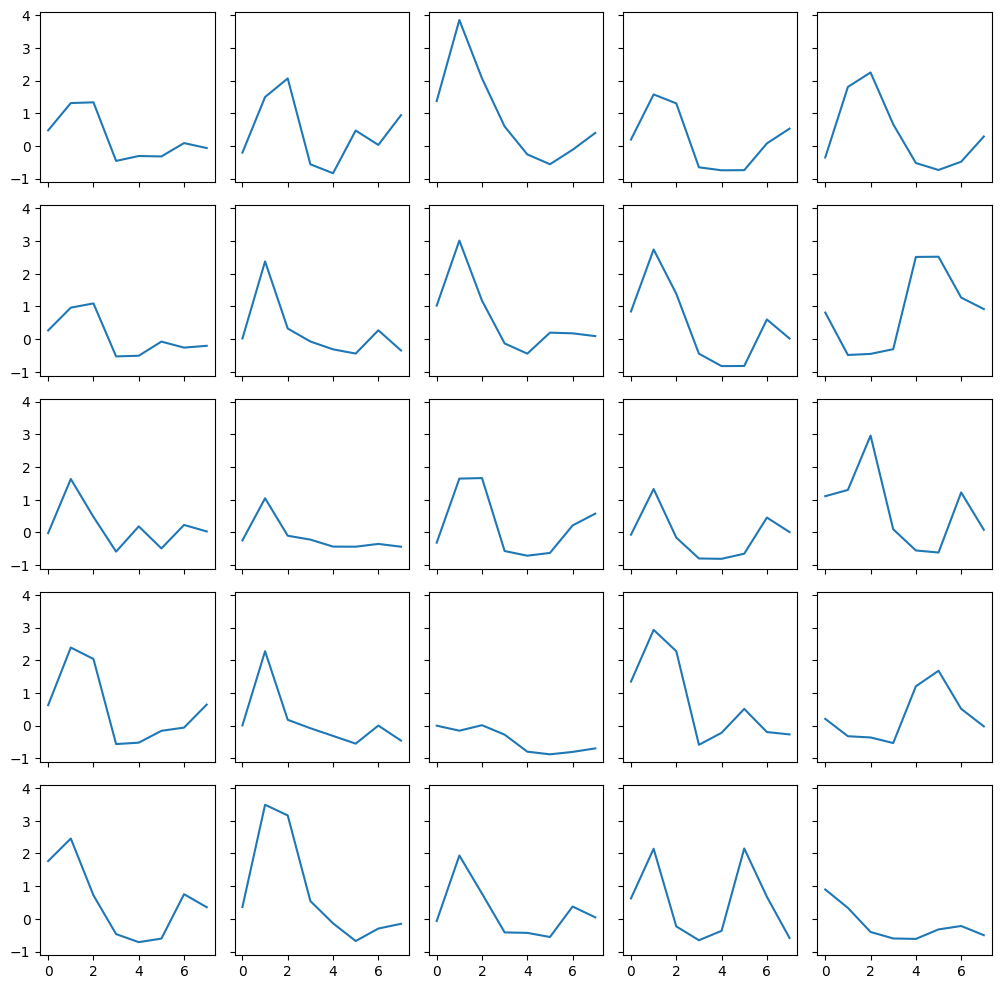

In [21]:
fig, axs = plt.subplots(5, 5, figsize=(10,10), sharex=True, sharey=True)

for i, p_data in enumerate(person_dataset.values()):
    x_idx = i % 5
    y_idx = i // 5
    ax = axs[x_idx, y_idx]

    f = p_data['features']
    a = p_data['actions']
    f = (f - f.mean()) / f.std()
    u_as = a.unique(dim=0)
    u_a = u_as[2]
    f_a = f[(a == u_a).all(dim=1)]

    ax.plot(f_a[0])

plt.tight_layout()

In [73]:
act_dim = all_actions.shape[-1]
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean", 
    n_jobs=1,
    random_state=0,
)
embeddings = reducer.fit_transform(all_feats)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [74]:
from sklearn.decomposition import KernelPCA

In [75]:
pca = KernelPCA(n_components=3).fit(all_feats.numpy())
pca_pred = pca.transform(all_feats.numpy())

In [76]:
def scatter_plot_embeddings(embeddings, c, title, ax, cmap="coolwarm", vmin=-1., vmax=1., s=4):
    ax.scatter(embeddings[:, 0], embeddings[:, 1], c=c, cmap=cmap, vmin=vmin, vmax=vmax, s=4)
    ax.set_title(title)
    return ax

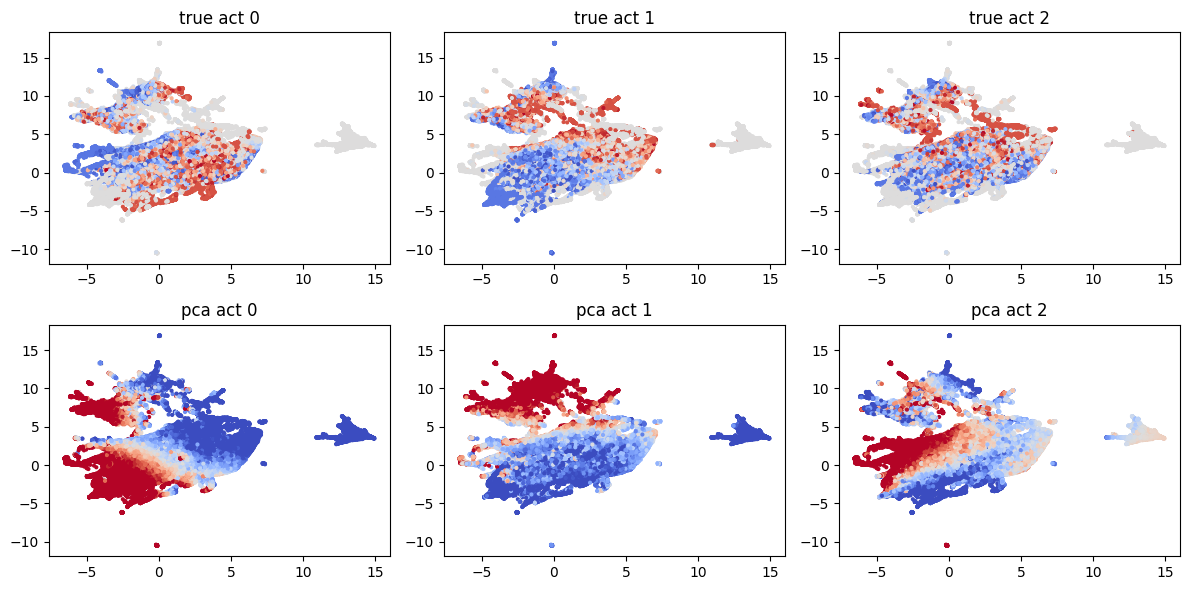

In [77]:
# visualize
fig, ax = plt.subplots(2, act_dim, figsize=(4 * act_dim, 6))
for i in range(act_dim):
    scatter_plot_embeddings(embeddings, all_actions[:, i], f"true act {i}", ax[0, i])
    scatter_plot_embeddings(embeddings, pca_pred[:, i], f"pca act {i}", ax[1, i])
plt.tight_layout()
plt.show()

In [78]:
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean",
    n_jobs=1,
    random_state=0,
)

embs_list = []
all_a_list = []  

for i, p_data in enumerate(person_dataset.values()):
    f = p_data['features']
    aug_f = p_data['aug_features']
    aug_a = p_data['aug_actions']
    a = p_data['actions']
    l = p_data['labels']

    all_f = torch.cat([f, aug_f], dim=0)
    all_a = torch.cat([a, aug_a], dim=0)

    embs = reducer.fit_transform(all_f)

    embs_list.append(embs)
    all_a_list.append(all_a)

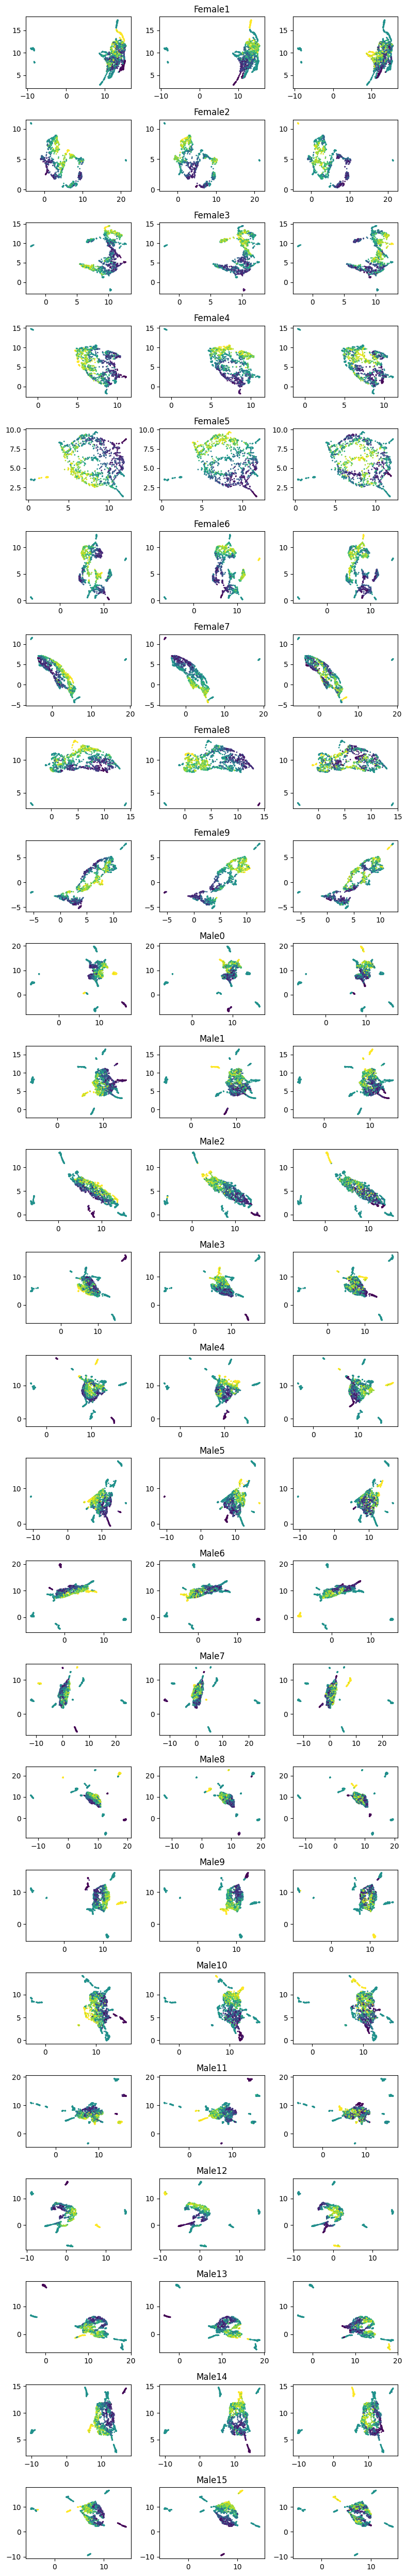

In [79]:
fig, axs = plt.subplots(len(person_dataset), 3, figsize=(8,50))
p_labels = list(person_dataset.keys())

for i, (embs, all_a) in enumerate(zip(embs_list, all_a_list)):
    c = all_a[:,0]
    c[c.abs() == 0.8] *= 1.3
    axs[i, 0].scatter(embs[:,0], embs[:,1], c=c, s=1.)
    c = all_a[:,1]
    c[c.abs() == 0.8] *= 1.3
    axs[i, 1].scatter(embs[:,0], embs[:,1], c=c, s=1.)
    c = all_a[:,2]
    c[c.abs() == 0.8] *= 1.3
    axs[i, 2].scatter(embs[:,0], embs[:,1], c=c, s=1.)
    axs[i, 1].set_title(p_labels[i])

plt.tight_layout()

In [80]:
import wandb

from lift.controllers import BCTrainer, MITrainer
from lift.environments.gym_envs import NpGymEnv
from lift.datasets import get_dataloaders
from lift.teacher import load_teacher

from pytorch_lightning.loggers import WandbLogger
import lightning as L

/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/pytorch_lightning/__init__.py:37: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages


In [81]:
env = NpGymEnv(
    "FetchReachDense-v2",
    cat_obs=True,
    cat_keys=config.teacher.env_cat_keys,
)

In [82]:
all_feats.shape, all_actions.shape

(torch.Size([38075, 8]), torch.Size([38075, 3]))

In [83]:
import torch.nn as nn

In [33]:
config.encoder.hidden_size = 512
config.encoder.n_layers = 4
config.encoder.dropout = 0.
config.pretrain.target_std = .5

model = BCTrainer(config, env, activation=nn.ReLU)
logger = WandbLogger(project='lift_test')

sl_data_dict = {
    "emg_obs": all_feats,
    "act": all_actions,
}
train_dataloader, val_dataloader = get_dataloaders(
    data_dict=sl_data_dict,
    train_ratio=config.pretrain.train_ratio,
    batch_size=config.pretrain.batch_size,
    num_workers=config.num_workers,
)

trainer = L.Trainer(
    max_epochs=150, 
    log_every_n_steps=1, 
    check_val_every_n_epoch=1,
    enable_checkpointing=False, 
    gradient_clip_val=config.gradient_clip_val,
    logger=logger,
)
trainer.fit(
    model=model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader,
)

wandb.run.finish()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilian. Use `wandb login --relogin` to force relogin
/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore



  | Name    | Type                | Params
------------------------------------------------
0 | encoder | TanhGaussianEncoder | 795 K 
------------------------------------------------
795 K     Trainable params
0         Non-trainable params
795 K     Total params
3.183     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▇▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_std,▇█▅▂█▆▁▇▆▅▆▆▄▆█▅▄▄▅▄▄▄▅▄▆▅▄▃▅▅▄▄▄▄▅▄▅▅▅▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_std,█▇▃▄▂▇▂▃▄▄▃▄▂▂▂▃▂▂▁▁▂▂▂▂▁▂▂▂▁▂▁▂▂▂▂▂▁▂▂▂
epoch,149
train_loss,0.00572
train_mae,0.07406


In [84]:
config.mi.beta_1 = .005 # mi weight, use 0.5 for mse
config.mi.beta_2 = 0.0 # kl weight
config.mi.beta_3 = 1.0 # sl weight

config.encoder.hidden_size = 512
config.encoder.n_layers = 4
config.encoder.dropout = 0.1

model = MITrainer(config, env, supervise=True)

logger = WandbLogger(project='lift_test', config=config.model_dump())

sl_data_dict = {
    "emg_obs": all_feats,
    "sl_act": all_actions,
}
train_dataloader, val_dataloader = get_dataloaders(
    data_dict=sl_data_dict,
    train_ratio=config.pretrain.train_ratio,
    batch_size=config.pretrain.batch_size,
    num_workers=config.num_workers,
)

trainer = L.Trainer(
    max_epochs=200, 
    log_every_n_steps=1, 
    check_val_every_n_epoch=1,
    enable_checkpointing=False, 
    gradient_clip_val=config.gradient_clip_val,
    logger=logger,
)
trainer.fit(
    model=model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader,
)

wandb.run.finish()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilian. Use `wandb login --relogin` to force relogin
/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore



  | Name    | Type                | Params
------------------------------------------------
0 | encoder | TanhGaussianEncoder | 795 K 
1 | critic  | MLP                 | 794 K 
------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.361     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/lift/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/act_mae,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy,█▇▇▆▆▆▆▆▅▄▄▄▄▄▃▄▃▄▃▂▃▂▃▃▃▂▃▁▂▂▃▂▁▁▂▂▁▁▁▁
train/log_post,▇▇▇▇▇▇▇▇███████████████████▇███▇▆▇██▆▁▇▇
train/log_prior,█▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▁▁
train/loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▆▅▅▄▄▄▃▃▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
train/mae_prior,▁▃▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▆▆▆▇▇▇▇▇▇▇▇▇██▇▇▇██▇█▇▇
train/mi_accuracy,▁▄▄▃▄▅▅▆▆▇▆▆▆▇▆▆▇▇▇▇▇▇▇██▇█▇█▇▇▇▇▇█▇▇▇▇▇
train/mi_loss,█▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/missalignment_mae,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
